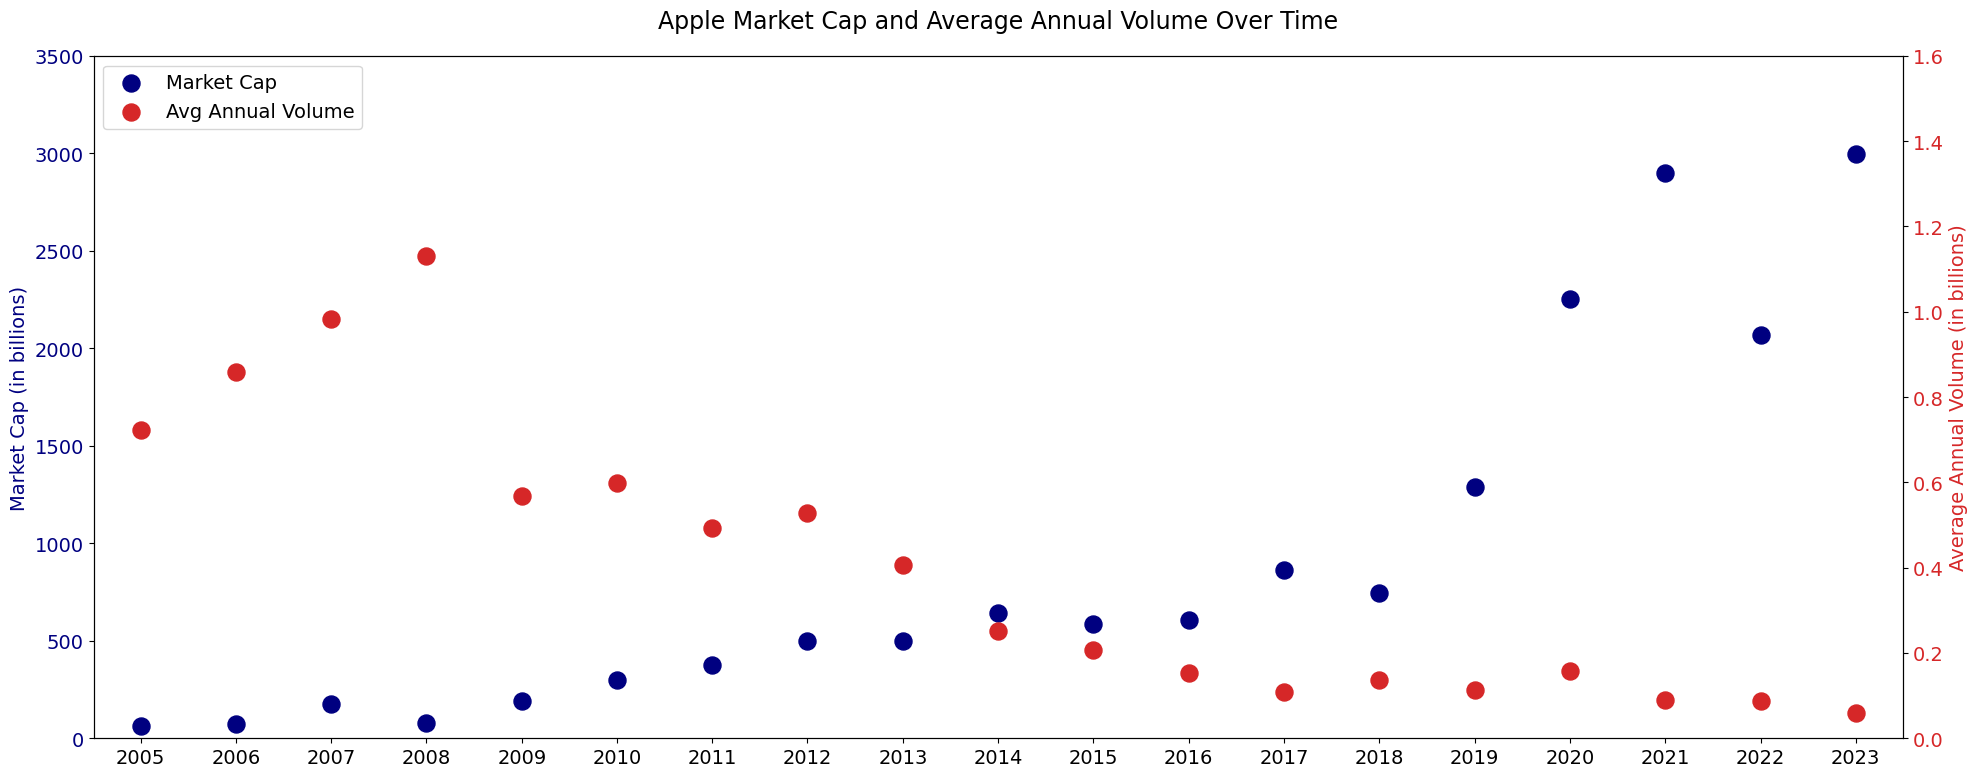

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

# Set the font
font = 'sans-serif'  
rcParams['font.family'] = font
rcParams['font.size'] = 14


# URL of the webpage containing the table
url = "https://companiesmarketcap.com/apple/marketcap/"

# Send a request to the website
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table in the HTML
table = soup.find('table')

# Convert the table to a DataFrame
MarketCap = pd.read_html(str(table))[0]
MarketCap.drop("Change", axis=1, inplace=True)

# Function to convert market cap to billions
def convert_to_billions(value):
    if 'T' in value:
        return float(value.replace('$', '').replace('T', '')) * 1000
    elif 'B' in value:
        return float(value.replace('$', '').replace('B', ''))
    else:
        return float(value)

# Apply the conversion to the 'Market cap' column
MarketCap['Market cap'] = MarketCap['Market cap'].apply(convert_to_billions)

# Download historical prices for Apple (AAPL) since 2001
prices = yf.download("AAPL", start="2001-01-01", progress=False)

# Calculate the average volume traded per year
avg_volume = prices["Volume"].resample('Y').mean()

# Create a new DataFrame for average annual volume
avg_volume_df = pd.DataFrame({
    'Year': avg_volume.index.year,
    'Average Annual Volume': avg_volume.values
})

# Merge this new DataFrame with the MarketCap DataFrame
merged_df_with_volume = pd.merge(MarketCap, avg_volume_df, on="Year", how="inner")

merged_df_with_volume.set_index("Year", inplace= True)

merged_df_with_volume = merged_df_with_volume.loc[:"2005"]

# Ensure the 'Year' index is a datetime type for proper plotting
merged_df_with_volume.index = pd.to_datetime(merged_df_with_volume.index, format='%Y')

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plotting Market Cap on the left y-axis
color_market_cap = 'Navy'
ax1.set_ylabel('Market Cap (in billions)', color=color_market_cap)
ax1.scatter(merged_df_with_volume.index, merged_df_with_volume['Market cap'], color=color_market_cap, label='Market Cap' , s = 150)
ax1.tick_params(axis='y', labelcolor=color_market_cap)
ax1.set_ylim(0, 3500)

# Set the x-axis limits to include 2005 and the year 2023 with a little space
padding = pd.DateOffset(days=180)
ax1.set_xlim(pd.Timestamp('2005-01-01') - padding, pd.Timestamp('2023-01-01') + padding)

# Use DateFormatter to display only the year part as the tick label
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Creating a second y-axis sharing the same x-axis for Average Annual Volume
ax2 = ax1.twinx()
color_volume = 'tab:red'
ax2.set_ylabel('Average Annual Volume (in billions)', color=color_volume)
avg_annual_volume_billions = merged_df_with_volume['Average Annual Volume'] / 1e9
ax2.scatter(merged_df_with_volume.index, avg_annual_volume_billions, color=color_volume, label='Avg Annual Volume', s = 150)
ax2.tick_params(axis='y', labelcolor=color_volume)
ax2.set_xlim(pd.Timestamp('2005-01-01') - padding, pd.Timestamp('2023-01-01') + padding)
ax2.set_ylim(0, 1.6)

# Add legends one over the other
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', frameon=True)

# Add title and layout adjustments
plt.title('Apple Market Cap and Average Annual Volume Over Time',fontsize = 17, pad=20)
fig.tight_layout()

# Display the plot
plt.show()